<a href="https://colab.research.google.com/github/birddropping/IND5003-Group-Project/blob/main/IND5003_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IND5003 Project Group 5
## Data Analysis and Model Building for diabetic condition prediction in patients
### Done by: Boey Zhi Shen Bryan, Tan Guo Shen Derek, M Saravanan and Tay Li Wen Wesley

# SECTION 1: DATA INGESTION AND FORMATION OF DATASET

In [68]:
#Import packages and functions needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline

In [69]:
#Import the 6 datasets together with the Dictionary file and Variables file
data_demo = pd.read_csv('data/demographic.csv')
data_diet = pd.read_csv('data/diet.csv')
data_exam = pd.read_csv('data/examination.csv')
data_labs = pd.read_csv('data/labs.csv')
data_meds = pd.read_csv('data/medications.csv', encoding = "ISO-8859-1") # Had to use this encoding standard to read file
data_qns = pd.read_csv('data/questionnaire.csv')
data_dict = pd.read_excel('NHANES 2014 Dictionary.xlsx')
#Variables file contains our down-selected variables based on availability of data and usefulness to hypothesis
data_vari = pd.read_excel('Variables.xlsx', squeeze = True)

In [70]:
# Fasting glucose was not part of the original dataset. Added from NHANES website
glu_data = pd.read_sas('data/GLU_H.XPT')
vitd_data = pd.read_sas('data/VID_H.XPT')

data_labs = pd.merge(data_labs, glu_data[['SEQN','LBDGLUSI']], how='outer', on=['SEQN'], validate = '1:1')
data_labs = pd.merge(data_labs, vitd_data[['SEQN','LBXVIDMS']], how='outer', on=['SEQN'], validate = '1:1')


In [71]:
#remove duplicates from data_meds as each line covers 1 medication
data_meds_m = data_meds.drop_duplicates(subset = ['SEQN', 'RXDCOUNT'], keep = 'first')


Combine the 6 datasets together as 1 with SEQN as the lead. From there, we can trim out the variables that is not needed for our application of diabetes and mental health. 'Outer' join was used for the merge function.

In [72]:
# Create massive dataset
dataset = pd.merge(data_demo, data_diet, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_exam, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_labs, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_meds_m, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_qns, how = 'outer', on = ['SEQN'], validate = "1:1")

dataset

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMQADFC,DMDBORN4,DMDCITZN,DMDYRSUS,DMDEDUC3,DMDEDUC2,DMDMARTL,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,AIALANGA,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGE,DMDHRBR4,DMDHREDU,DMDHRMAR,DMDHSEDU,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,PEASCST1,PEASCTM1,PEASCCT1,BPXCHR,BPAARM,BPACSZ,BPXPLS,BPXPULS,BPXPTY,BPXML1,BPXSY1,BPXDI1,BPAEN1,BPXSY2,BPXDI2,BPAEN2,BPXSY3,BPXDI3,BPAEN3,BPXSY4,BPXDI4,BPAEN4,BMDSTATS,BMXWT,BMIWT,BMXRECUM,BMIRECUM,BMXHEAD,BMIHEAD,BMXHT,BMIHT,BMXBMI,BMDBMIC,BMXLEG,BMILEG,BMXARML,...,PAQ755,PAQ759A,PAQ759B,PAQ759C,PAQ759D,PAQ759E,PAQ759F,PAQ759G,PAQ759H,PAQ759I,PAQ759J,PAQ759K,PAQ759L,PAQ759M,PAQ759N,PAQ759O,PAQ759P,PAQ759Q,PAQ759R,PAQ759S,PAQ759T,PAQ759U,PAQ759V,PAQ762,PAQ764,PAQ766,PAQ679,PAQ750,PAQ770,PAQ772A,PAQ772B,PAQ772C,PAAQUEX,PUQ100,PUQ110,RHQ010,RHQ020,RHQ031,RHD043,RHQ060,RHQ070,RHQ074,RHQ076,RHQ078,RHQ131,RHD143,RHQ160,RHQ162,RHQ163,RHQ166,RHQ169,RHQ172,RHD173,RHQ171,RHD180,RHD190,RHQ197,RHQ200,RHD280,RHQ291,RHQ305,RHQ332,RHQ420,RHQ540,RHQ542A,RHQ542B,RHQ542C,RHQ542D,RHQ554,RHQ560Q,RHQ560U,RHQ570,RHQ576Q,RHQ576U,RHQ580,RHQ586Q,RHQ586U,RHQ596,RHQ602Q,RHQ602U,RXQ510,RXQ515,RXQ520,RXQ525G,RXQ525Q,RXQ525U,RXD530,SLD010H,SLQ050,SLQ060,SMQ020,SMD030,SMQ040,SMQ050Q,SMQ050U,SMD055,SMD057,SMQ078,SMD641,SMD650,SMD093,SMDUPCA,SMD100BR,SMD100FL,SMD100MN,SMD100LN,SMD100TR,SMD100NI,SMD100CO,SMQ621,SMD630,SMQ661,SMQ665A,SMQ665B,SMQ665C,SMQ665D,SMQ670,SMQ848,SMQ852Q,SMQ852U,SMAQUEX2,SMD460,SMD470,SMD480,SMQ856,SMQ858,SMQ860,SMQ862,SMQ866,SMQ868,SMQ870,SMQ872,SMQ874,SMQ876,SMQ878,SMQ880,SMAQUEX.x,SMQ681,SMQ690A,SMQ710,SMQ720,SMQ725,SMQ690B,SMQ740,SMQ690C,SMQ770,SMQ690G,SMQ845,SMQ690H,SMQ849,SMQ851,SMQ690D,SMQ800,SMQ690E,SMQ817,SMQ690I,SMQ857,SMQ690J,SMQ861,SMQ863,SMQ690F,SMQ830,SMQ840,SMDANY,SMAQUEX.y,SXD021,SXQ800,SXQ803,SXQ806,SXQ809,SXQ700,SXQ703,SXQ706,SXQ709,SXD031,SXD171,SXD510,SXQ824,SXQ827,SXD633,SXQ636,SXQ639,SXD642,SXQ410,SXQ550,SXQ836,SXQ841,SXQ853,SXD621,SXQ624,SXQ627,SXD630,SXQ645,SXQ648,SXQ610,SXQ251,SXQ590,SXQ600,SXD101,SXD450,SXQ724,SXQ727,SXQ130,SXQ490,SXQ741,SXQ753,SXQ260,SXQ265,SXQ267,SXQ270,SXQ272,SXQ280,SXQ292,SXQ294,WHD010,WHD020,WHQ030,WHQ040,WHD050,WHQ060,WHQ070,WHD080A,WHD080B,WHD080C,WHD080D,WHD080E,WHD080F,WHD080G,WHD080H,WHD080I,WHD080J,WHD080K,WHD080M,WHD080N,WHD080O,WHD080P,WHD080Q,WHD080R,WHD080S,WHD080T,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,1.0,1.0,1,1

In [73]:
# Create list of variables of interest
col_list = data_vari.tolist()

# Creating dataframe with variables of interest
final_data = dataset[col_list]

# Subsetting based on glycohaemoglobin levels
final_data = final_data.dropna(subset=['LBXGH']) 

final_data

,SEQN,RXDCOUNT,RXDDAYS,RIAGENDR,RIDAGEYR,RIDRETH1,BMXBMI,BPXSY1,BPXDI1,BPXSY2,BPXDI2,BPXSY3,BPXDI3,DR1TALCO,DR1.320Z,LBDGLTSI,LBDGLUSI,LBDHDDSI,LBDTCSI,LBXVIDMS,LBXGH,DIQ160,DIQ170,DIQ172,DIQ175A,DBD895,DBD900,DBD905,DBD910,FSD151,FSQ165,INDHHIN2,INDFMIN2,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100,PAQ605,PAQ610,PAD615,PAQ620,PAQ625,PAD630,PAQ635,PAQ640,PAD645,PAQ650,PAQ655,PAD660,PAQ665,PAQ670,PAD675,PAD680,PAQ710,PAQ715,WHQ030,WHQ070,DBQ700,HSD010,WHD110,WHD120,BMXWT
0,73557,2.0,NaN,1,69,4,26.7,122.0,72.0,114.0,76.0,102.0,74.0,0.0,960.0,NaN,NaN,1.68,4.32,28.9,13.9,NaN,NaN,NaN,NaN,8.0,8.0,0.0,4.0,2.0,1.0,4.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,600.0,2.0,8.0,3.0,NaN,2.0,2.0,270.0,200.0,78.3
1,73558,4.0,243.0,1,54,3,28.6,156.0,62.0,160.0,80.0,156.0,42.0,119.0,360.0,NaN,NaN,1.29,4.40,61.9,9.1,NaN,NaN,NaN,NaN,0.0,NaN,0.0,2.0,2.0,1.0,7.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,1.0,1.0,10.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,540.0,4.0,8.0,3.0,2.0,3.0,4.0,240.0,250.0,89.5
2,73559,5.0,365.0,1,72,3,28.9,140.0,90.0,140.0,76.0,146.0,80.0,0.0,1254.0,NaN,10.713,1.55,3.26,126.0,8.9,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,2.0,2.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,1.0,7.0,30.0,2.0,NaN,NaN,2.0,NaN,NaN,1.0,1.0,180.0,300.0,4.0,0.0,3.0,2.0,3.0,3.0,180.0,190.0,88.9
4,73561,4.0,152.0,2,73,3,19.7,136.0,86.0,134.0,88.0,142.0,86.0,0.0,240.0,NaN,5.940,2.20,5.20,108.0,4.9,2.0,2.0,2.0,NaN,0.0,NaN,4.0,1.0,2.0,2.0,15.0,15.0,2.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,2.0,NaN,NaN,1.0,2.0,30.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,480.0,1.0,1.0,2.0,2.0,2.0,5.0,150.0,135.0,52.0
5,73562,7.0,365.0,1,56,1,41.7,160.0,84.0,158.0,82.0,154.0,80.0,0.0,1014.0,NaN,NaN,0.98,5.84,44.3,5.5,2.0,2.0,1.0,NaN,14.0,14.0,0.0,0.0,2.0,2.0,9.0,9.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,1.0,0.0,3.0,1.0,5.0,240.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,360.0,5.0,8.0,1.0,1.0,5.0,5.0,225.0,195.0,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10164,83721,1.0,91.0,1,52,3,25.6,108.0,70.0,112.0,72.0,108.0,76.0,0.0,0.0,NaN,NaN,1.42,3.57,109.0,5.4,2.0,2.0,2.0,NaN,15.0,0.0,0.0,0.0,2.0,2.0,15.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,4.0,120.0,1.0,3.0,120.0,240.0,2.0,8.0,3.0,2.0,1.0,2.0,172.0,163.0,79.5
10166,83723,NaN,NaN,1,61,1,33.1,NaN,NaN,138.0,60.0,142.0,68.0,0.0,3000.0,NaN,8.826,1.27,4.81,59.4,7.4,NaN,NaN,NaN,NaN,1.0,0.0,0.0,2.0,2.0,1.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,2.0,30.0,360.0,3.0,8.0,1.0,NaN,3.0,4.0,240.0,200.0,99.5
10167,83724,5.0,10950.0,1,80,3,24.9,164.0,70.0,168.0,66.0,168.0,66.0,0.0,690.0,NaN,NaN,1.32,4.06,89.9,5.5,2.0,2.0,2.0,NaN,1.0,1.0,0.0,30.0,2.0,2.0,8.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,7.0,60.0,360.0,2.0,8.0,3.0,2.0,2.0,2.0,173.0,140.0,77.1
10170,83727,NaN,NaN,1,26,2,24.5,110.0,68.0,116.0,74.0,112.0,76.0,14.0,867.0,5.995,5.995,1.42,4.91,81.5,5.0,2.0,2.0,2.0,NaN,1.0,1.0,2.0,2.0,2.0,2.0,77.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,600.0,2.0,1.0,3.0,2.0,4.0,3.0,NaN,NaN,71.8


'LBXGH' which refers to the results of the Glycohemoglobin test will be used as the target variable to identify if a patient has diabetes. The exact cut off point is if the variable result is $\ge$ to 6.5, the patient is catergorised as diabetic.

In [74]:
X = final_data.drop('LBXGH', axis=1)
y = np.where(final_data['LBXGH'] >=6.5, 1, 0)

Train-test split of data is carried out before the data cleaning/pre-processing section. The reason is that we should train our model on the training data, without using any information regarding the test data. If we apply PCA on the whole data (including the test data) before training the model, then we in fact use some information from the test data. Thus, we cannot really judge the behaviour of our model using the test data, because it is not an unseen data anymore.

In [75]:
#Train-test split with 20% test data set aside
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

# SECTION 2: DATA CLEANING/PRE-PROCESSING

In [76]:
#4 Variables have been selected to represent the socioeconomic status of the patient
SES = ['INDHHIN2', 'INDFMIN2', 'FSD151', 'FSQ165']
SES_data_train = X_train[SES]
SES_data_test = X_test[SES]

Coded results for household/family income

|Value|Salary Range|
|-----|------------|
|1|0 to 4999|
|2|5000 to 9999|
|3|10000 to 14999|
|4|15000 to 19999|
|5|20000 to 24999|
|6|25000 to 34999|
|7|35000 to 44999|
|8|45000 to 54999|
|9|55000 to 64999|
|10|65000 to 74999|
|12|20000 and over|
|13|under 20000|
|14|75000 to 99999|
|15|100000 and over|

We will have to replace NaN values, 77 and 99 which are refuse to answer and do not know respectively.

In [77]:
#Replace 77.0 and 99.0 with NaN value first, before replacing all NaN values with the mean of the remainder.
SES_data_train.loc[:,'INDHHIN2'] = SES_data_train.loc[:,'INDHHIN2'].replace(77.0, np.NaN)
SES_data_train.loc[:,'INDHHIN2'] = SES_data_train.loc[:,'INDHHIN2'].replace(99.0, np.NaN)
SES_data_test.loc[:,'INDHHIN2'] = SES_data_test.loc[:,'INDHHIN2'].replace(77.0, np.NaN)
SES_data_test.loc[:,'INDHHIN2'] = SES_data_test.loc[:,'INDHHIN2'].replace(99.0, np.NaN)
#Round function used to keep integer values only within the Dataframe
SES_data_train.loc[:,'INDHHIN2'] = SES_data_train.loc[:,'INDHHIN2'].fillna(round(SES_data_train.loc[:,'INDHHIN2'].mean()))
SES_data_test.loc[:,'INDHHIN2'] = SES_data_test.loc[:,'INDHHIN2'].fillna(round(SES_data_train.loc[:,'INDHHIN2'].mean()))


SES_data_train.loc[:,'INDFMIN2'] = SES_data_train.loc[:,'INDFMIN2'].replace(77.0, np.NaN)
SES_data_train.loc[:,'INDFMIN2'] = SES_data_train.loc[:,'INDFMIN2'].replace(99.0, np.NaN)
SES_data_test.loc[:,'INDFMIN2'] = SES_data_test.loc[:,'INDFMIN2'].replace(77.0, np.NaN)
SES_data_test.loc[:,'INDFMIN2'] = SES_data_test.loc[:,'INDFMIN2'].replace(99.0, np.NaN)
#Round function used to keep integer values only within the Dataframe
SES_data_train.loc[:,'INDFMIN2'] = SES_data_train.loc[:,'INDFMIN2'].fillna(round(SES_data_train.loc[:,'INDFMIN2'].mean()))
SES_data_test.loc[:,'INDFMIN2'] = SES_data_test.loc[:,'INDFMIN2'].fillna(round(SES_data_train.loc[:,'INDFMIN2'].mean()))

In [78]:
#Too many catergories that are not in order to make sense when plotting a histogram
#Convert data values to only have 4 catergories

#Cat 1 is under 20000
replace_values_cat1 = {2:1, 3:1, 4:1, 13:1}
#Cat 2 is 20000 to 74999
replace_values_cat2 = {5:2, 6:2, 7:2, 8:2, 9:2, 10:2, 12:2}
#Cat 3 is 75000 to 99999
replace_values_cat3 = {14:3}
#Cat 4 is 100000 and above
replace_values_cat4 = {15:4}

#Replace the values in 'INDHHIN2' to create 4 catergories
SES_data_train['INDHHIN2'].replace(replace_values_cat1, inplace=True)
SES_data_train['INDHHIN2'].replace(replace_values_cat2, inplace=True)
SES_data_train['INDHHIN2'].replace(replace_values_cat3, inplace=True)
SES_data_train['INDHHIN2'].replace(replace_values_cat4, inplace=True)
SES_data_test['INDHHIN2'].replace(replace_values_cat1, inplace=True)
SES_data_test['INDHHIN2'].replace(replace_values_cat2, inplace=True)
SES_data_test['INDHHIN2'].replace(replace_values_cat3, inplace=True)
SES_data_test['INDHHIN2'].replace(replace_values_cat4, inplace=True)

#Replace the values in 'INDFMIN2' to create 4 catergories
SES_data_train['INDFMIN2'].replace(replace_values_cat1, inplace=True)
SES_data_train['INDFMIN2'].replace(replace_values_cat2, inplace=True)
SES_data_train['INDFMIN2'].replace(replace_values_cat3, inplace=True)
SES_data_train['INDFMIN2'].replace(replace_values_cat4, inplace=True)
SES_data_test['INDFMIN2'].replace(replace_values_cat1, inplace=True)
SES_data_test['INDFMIN2'].replace(replace_values_cat2, inplace=True)
SES_data_test['INDFMIN2'].replace(replace_values_cat3, inplace=True)
SES_data_test['INDFMIN2'].replace(replace_values_cat4, inplace=True)

#Replace the original values in the train and test data with the modified values
X_train.loc[:,'INDFMIN2'] = SES_data_train.loc[:,'INDFMIN2']
X_train.loc[:,'INDHHIN2'] = SES_data_train.loc[:,'INDHHIN2']
X_test.loc[:,'INDFMIN2'] = SES_data_test.loc[:,'INDFMIN2']
X_test.loc[:,'INDHHIN2'] = SES_data_test.loc[:,'INDHHIN2']

In [79]:
#check that the value 11 is not in the column as it is not represented in the value coding table above for feature
# INDHHIN2 and INDFMIN2 which are household income and family income respectively
check=[11]
SES_data_train['INDHHIN2'].isin(check).sum()

0

In [80]:
SES_data_train['INDFMIN2'].isin(check).sum()

0

In [81]:
#Replace the 'did not answer' and 'did not know' values with 'NaN' value for 'FSD151'
SES_data_train['FSD151'].replace(7.0, np.NaN, inplace=True)
SES_data_train['FSD151'].replace(9.0, np.NaN, inplace=True)
SES_data_test['FSD151'].replace(7.0, np.NaN, inplace=True)
SES_data_test['FSD151'].replace(9.0, np.NaN, inplace=True)
#Round function used to keep integer values only within the Dataframe
SES_data_train['FSD151'].fillna(round(SES_data_train['FSD151'].mean()), inplace=True)
SES_data_test['FSD151'].fillna(round(SES_data_train['FSD151'].mean()), inplace=True)

#Replace the 'did not answer' and 'did not know' values with 'NaN' value for 'FSQ165'
SES_data_train['FSQ165'].replace(7.0, np.NaN, inplace=True)
SES_data_train['FSQ165'].replace(9.0, np.NaN, inplace=True)
SES_data_test['FSQ165'].replace(7.0, np.NaN, inplace=True)
SES_data_test['FSQ165'].replace(9.0, np.NaN, inplace=True)
#Round function used to keep integer values only within the Dataframe
SES_data_train['FSQ165'].fillna(round(SES_data_train['FSQ165'].mean()), inplace=True)
SES_data_test['FSQ165'].fillna(round(SES_data_train['FSQ165'].mean()), inplace=True)

#Replace the original values in the train and test data with the modified values
X_train['FSD151'] = SES_data_train['FSD151']
X_train['FSQ165'] = SES_data_train['FSQ165']
X_test['FSD151'] = SES_data_test['FSD151']
X_test['FSQ165'] = SES_data_test['FSQ165']

In [82]:
# subsetting dataset based on available HbA1c data
mh = ['SEQN','DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090','DPQ100']
mental_health_train = X_train[mh]
mental_health_test = X_test[mh]

#Summing up the scores
mental_health_train.loc[:,'DPQ_score'] = mental_health_train.drop('SEQN', axis=1).sum(axis=1)
mental_health_test.loc[:,'DPQ_score'] = mental_health_test.drop('SEQN', axis=1).sum(axis=1)

# mental health summary statistic - 4 categories - 0 for normal, 1 for mild, 2 for moderate, 3 for severe
X_train.loc[:,'mental_health_stat'] = pd.cut(mental_health_train['DPQ_score'], [0,4,9,14,27], labels=[0,1,2,3], include_lowest = True)
X_test.loc[:,'mental_health_stat'] = pd.cut(mental_health_test['DPQ_score'], [0,4,9,14,27], labels=[0,1,2,3], include_lowest = True)

#Drop the constituent variables since 'mental_health_stat' has been created
X_train = X_train.drop(['DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090','DPQ100'], axis=1)
X_test = X_test.drop(['DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090','DPQ100'], axis=1)

In [83]:
# selecting average value for individuals with no inputs, replacing 'unsure' responses with average value
X_train.loc[:,'WHQ030'] = X_train['WHQ030'].fillna(3).replace(9,3) 
X_test.loc[:,'WHQ030'] = X_test['WHQ030'].fillna(3).replace(9,3) 
# selecting 'no' for individuals who did not respond to this qn, replacing 'unsure' responses with nil response
X_train.loc[:,'WHQ070'] = X_train['WHQ070'].fillna(2).replace(9,2) 
X_test.loc[:,'WHQ070'] = X_test['WHQ070'].fillna(2).replace(9,2) 
# selecting average value for individuals with no inputs, replacing 'unsure' responses with average value
X_train.loc[:,'DBQ700'] = X_train['DBQ700'].fillna(3).replace(9,3)
X_test.loc[:,'DBQ700'] = X_test['DBQ700'].fillna(3).replace(9,3)
# selecting average value for individuals with no inputs, replacing 'unsure' responses with average value\
X_train.loc[:,'HSD010'] = X_train['HSD010'].fillna(3).replace(9,3)
X_test.loc[:,'HSD010'] = X_test['HSD010'].fillna(3).replace(9,3)

# Subsetting and creating scores for individual self-perception questions
sp = ['SEQN','WHQ030','WHQ070','DBQ700', 'HSD010']
self_perception_train = X_train[sp]
self_perception_test = X_test[sp]
self_perception_train.loc[:,'WHQ030_score'] = self_perception_train['WHQ030'].replace([1,2],0).replace(3,2)
self_perception_train.loc[:,'WHQ070_score'] = self_perception_train['WHQ070'].replace(1,0)
self_perception_train.loc[:,'DBQ700_score'] = self_perception_train['DBQ700']-1
self_perception_train.loc[:,'HSD010_score'] = self_perception_train['HSD010']-1
self_perception_test.loc[:,'WHQ030_score'] = self_perception_test['WHQ030'].replace([1,2],0).replace(3,2)
self_perception_test.loc[:,'WHQ070_score'] = self_perception_test['WHQ070'].replace(1,0)
self_perception_test.loc[:,'DBQ700_score'] = self_perception_test['DBQ700']-1
self_perception_test.loc[:,'HSD010_score'] = self_perception_test['HSD010']-1

# Creating summary score for self perception
self_perception_train.loc[:,'self_perception_stat'] = self_perception_train[['WHQ030_score','WHQ070_score','DBQ700_score','HSD010_score']].sum(axis=1)
X_train.loc[:,'self_perception_stat'] = pd.cut(self_perception_train.loc[:,'self_perception_stat'], [0,3,6,9,12], labels=[0,1,2,3], include_lowest = True)
self_perception_test.loc[:,'self_perception_stat'] = self_perception_test[['WHQ030_score','WHQ070_score','DBQ700_score','HSD010_score']].sum(axis=1)
X_test.loc[:,'self_perception_stat'] = pd.cut(self_perception_test.loc[:,'self_perception_stat'], [0,3,6,9,12], labels=[0,1,2,3], include_lowest = True)

#Drop the constituent variables since 'self_perception_stat' has been created
X_train = X_train.drop(['WHQ030','WHQ070','DBQ700','HSD010'], axis=1)
X_test = X_test.drop(['WHQ030','WHQ070','DBQ700','HSD010'], axis=1)

In [84]:
# Cleaning number of medications
X_train['RXDCOUNT'] = X_train['RXDCOUNT'].replace(np.NaN, 0)
X_test['RXDCOUNT'] = X_test['RXDCOUNT'].replace(np.NaN, 0)

# Defining average blood pressure
X_train.loc[:,'AVGSYBP'] = round(X_train[['BPXSY1','BPXSY2','BPXSY3']].mean(axis=1))
X_train.loc[:,'AVGDIBP'] = round(X_train[['BPXDI1','BPXDI2','BPXDI3']].mean(axis=1))
X_test.loc[:,'AVGSYBP'] = round(X_test[['BPXSY1','BPXSY2','BPXSY3']].mean(axis=1))
X_test.loc[:,'AVGDIBP'] = round(X_test[['BPXDI1','BPXDI2','BPXDI3']].mean(axis=1))

# Dropping base variables relating to 1,2,3 measurements of Systolic and Diastolic BP
X_train = X_train.drop(['BPXSY1','BPXSY2','BPXSY3','BPXDI1','BPXDI2','BPXDI3'], axis=1)
X_test = X_test.drop(['BPXSY1','BPXSY2','BPXSY3','BPXDI1','BPXDI2','BPXDI3'], axis=1)

# Cleaning data for DBD895. >21 responses normalized to 21. Unsure participants normalized to mean number of meals based on train set
X_train['DBD895'] = X_train['DBD895'].replace({5555:21, 9999:np.NaN, 7777:np.NaN}).replace(np.NaN, round(np.mean(X_train['DBD895'])))
X_train['DBD900'] = X_train['DBD900'].replace({5555:21, 9999:np.NaN}).replace(np.NaN, round(np.mean(X_train['DBD900'])))
X_test['DBD895'] = X_test['DBD895'].replace({5555:21, 9999:np.NaN, 7777:np.NaN}).replace(np.NaN, round(np.mean(X_train['DBD895'])))
X_test['DBD900'] = X_test['DBD900'].replace({5555:21, 9999:np.NaN}).replace(np.NaN, round(np.mean(X_train['DBD900'])))

# Calculating proportion of fast food compared to all other meals consumed outside
avg_meals_train = X_train['DBD900'] / X_train['DBD895']
avg_meals_train = avg_meals_train.replace(np.inf, 0)
avg_meals_train = avg_meals_train.where(avg_meals_train < 1 ,1)
X_train['PROFFMEAL'] = avg_meals_train
avg_meals_test = X_test['DBD900'] / X_test['DBD895']
avg_meals_test = avg_meals_test.replace(np.inf, 0)
avg_meals_test = avg_meals_test.where(avg_meals_test < 1 ,1)
X_test['PROFFMEAL'] = avg_meals_test

X_train['DBD905'] = X_train['DBD905'].replace(9999, np.NaN).replace(np.NaN, round(np.mean(X_train['DBD905'])))   
X_train['DBD910'] = X_train['DBD910'].replace(9999, np.NaN).replace(np.NaN, round(np.mean(X_train['DBD910'])))   
X_test['DBD905'] = X_test['DBD905'].replace(9999, np.NaN).replace(np.NaN, round(np.mean(X_train['DBD905'])))   
X_test['DBD910'] = X_test['DBD910'].replace(9999, np.NaN).replace(np.NaN, round(np.mean(X_train['DBD910'])))   

#Drop the constituent variables
X_train.drop(['RXDDAYS','LBDGLTSI','LBDGLUSI','DIQ160','DIQ170','DIQ172','DIQ175A','WHD110','WHD120','BMXWT','SEQN'],axis=1, inplace=True)
X_test.drop(['RXDDAYS','LBDGLTSI','LBDGLUSI','DIQ160','DIQ170','DIQ172','DIQ175A','WHD110','WHD120','BMXWT','SEQN'],axis=1, inplace=True)

In [85]:
#Create working database for activity
activity = ["PAQ605", "PAQ620", "PAQ635", "PAQ650", "PAQ665", "PAD680", "PAQ710", "PAQ715"]
activity_wk_train = X_train.loc[:,activity]
activity_wk_test = X_test.loc[:,activity]

#drop "PAQ706" due to poor data
#code out target variable "DM"
#code activity levels
activity1 = ["PAQ605", "PAQ620", "PAQ635", "PAQ650", "PAQ665", "PAD680", "PAQ710", "PAQ715"]
activity_wk_train = X_train.loc[:,activity1]
#activity_wk_train["DM"] = activity_wk_train["LBXGH"]>6.5
activity_wk_train["activity_lvl_high"] = np.where((activity_wk_train.PAQ650 == 1) | (activity_wk_train.PAQ605 == 1), 1, np.NaN)
activity_wk_train["activity_lvl_med"] = np.where((activity_wk_train["PAQ620"] == 1) | (activity_wk_train["PAQ665"] == 1), 2, np.NaN)
activity_wk_train["activity_lvl_low"] =  (activity_wk_train["PAQ605" and "PAQ650" and "PAQ620" and "PAQ665"] !=1)
activity_wk_test = X_test.loc[:,activity1]
#activity_wk_test["DM"] = activity_wk_test["LBXGH"]>6.5
activity_wk_test["activity_lvl_high"] = np.where((activity_wk_test.PAQ650 == 1) | (activity_wk_test.PAQ605 == 1), 1, np.NaN)
activity_wk_test["activity_lvl_med"] = np.where((activity_wk_test["PAQ620"] == 1) | (activity_wk_test["PAQ665"] == 1), 2, np.NaN)
activity_wk_test["activity_lvl_low"] =  (activity_wk_test["PAQ605" and "PAQ650" and "PAQ620" and "PAQ665"] !=1)

activity_wk_train["activity_lvl_low"].replace(True, 3, inplace=True)
activity_wk_train["activity_lvl_low"].replace(False, np.NaN, inplace=True)
#activity_wk[activity_wk["activity_lvl_high"]==0].replace(0,activity_wk["activity_lvl_med"], inplace=True )
#activity_wk["activity_lvl_high"].replace(0,activity_wk["activity_lvl_med"], inplace =True)
activity_wk_train["activity_lvl"] = activity_wk_train[["activity_lvl_high", "activity_lvl_med", "activity_lvl_low"]].min(axis=1)
activity_wk_test["activity_lvl_low"].replace(True, 3, inplace=True)
activity_wk_test["activity_lvl_low"].replace(False, np.NaN, inplace=True)
activity_wk_test["activity_lvl"] = activity_wk_test[["activity_lvl_high", "activity_lvl_med", "activity_lvl_low"]].min(axis=1)


X_train['activity_lvl'] = activity_wk_train['activity_lvl']
X_test['activity_lvl'] = activity_wk_test['activity_lvl']

#Drop the constituent variables since three activity levels variables have been created
X_train.drop(["PAQ605",'PAQ610','PAD615', "PAQ620",'PAQ625','PAD630', "PAQ635", 'PAQ640','PAD645', "PAQ650", 'PAQ655','PAD660', "PAQ665", 'PAQ670','PAD675', "PAD680", "PAQ710", "PAQ715"], axis=1, inplace=True)
X_test.drop(["PAQ605",'PAQ610','PAD615', "PAQ620",'PAQ625','PAD630', "PAQ635", 'PAQ640','PAD645', "PAQ650", 'PAQ655','PAD660', "PAQ665", 'PAQ670','PAD675', "PAD680", "PAQ710", "PAQ715"], axis=1, inplace=True)

In [86]:
# Reindexing train and test sets for dropping of NA values. 

X_train = X_train.reset_index().drop('index',axis=1)
tmp_train = pd.concat((X_train, pd.DataFrame(y_train)), axis=1)

X_test = X_test.reset_index().drop('index',axis=1)
tmp_test = pd.concat((X_test, pd.DataFrame(y_test)), axis=1)

tmp_train.dropna(axis=0,how='any', inplace = True)
tmp_test.dropna(axis=0,how='any', inplace = True)

In [87]:
X_train = tmp_train.drop(0,axis=1)
y_train = tmp_train.iloc[:,-1]
X_test = tmp_test.drop(0,axis=1)
y_test = tmp_test.iloc[:,-1]

In [88]:
X_train

,RXDCOUNT,RIAGENDR,RIDAGEYR,RIDRETH1,BMXBMI,DR1TALCO,DR1.320Z,LBDHDDSI,LBDTCSI,LBXVIDMS,DBD895,DBD900,DBD905,DBD910,FSD151,FSQ165,INDHHIN2,INDFMIN2,mental_health_stat,self_perception_stat,AVGSYBP,AVGDIBP,PROFFMEAL,activity_lvl
0,0.0,1,55,5,24.6,29.1,0.0,0.91,4.65,38.4,0.0,5.0,0.0,0.0,2.0,2.0,2.0,2.0,0,2,152.0,85.0,0.000000,3.0
1,1.0,1,30,5,14.1,0.0,240.0,1.29,4.06,39.5,0.0,5.0,0.0,0.0,1.0,1.0,2.0,2.0,1,2,109.0,65.0,0.000000,3.0
2,3.0,2,66,2,27.0,4.7,150.0,1.11,6.39,74.4,0.0,5.0,0.0,0.0,2.0,1.0,1.0,1.0,3,2,170.0,96.0,0.000000,3.0
3,2.0,2,47,5,21.4,0.0,1095.0,1.40,4.76,94.4,3.0,2.0,1.0,2.0,2.0,2.0,3.0,3.0,0,1,105.0,65.0,0.666667,1.0
4,0.0,2,42,3,37.2,0.0,5760.0,1.24,3.18,58.3,10.0,5.0,15.0,15.0,2.0,2.0,3.0,3.0,0,1,109.0,68.0,0.500000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5308,0.0,1,36,3,23.6,11.2,180.0,1.19,3.54,73.7,5.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,0,2,119.0,85.0,0.600000,1.0
5309,2.0,2,70,4,22.0,0.0,525.0,1.37,4.97,35.6,5.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,0,2,155.0,80.0,0.000000,3.0
5310,7.0,2,74,3,22.1,19.2,1575.0,0.91,5.51,113.0,2.0,0.0,12.0,0.0,2.0,2.0,2.0,2.0,0,2,127.0,57.0,0.000000,3.0
5312,0.0,2,20,4,23.8,0.0,75.0,2.07,4.22,43.9,0.0,5.0,2.0,3.0,2.0,2.0,3.0,3.0,0,1,107.0,67.0,0.000000,1.0


In [89]:
X_test

,RXDCOUNT,RIAGENDR,RIDAGEYR,RIDRETH1,BMXBMI,DR1TALCO,DR1.320Z,LBDHDDSI,LBDTCSI,LBXVIDMS,DBD895,DBD900,DBD905,DBD910,FSD151,FSQ165,INDHHIN2,INDFMIN2,mental_health_stat,self_perception_stat,AVGSYBP,AVGDIBP,PROFFMEAL,activity_lvl
0,0.0,2,37,2,21.5,0.0,1200.00,1.68,6.00,56.4,3.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,0,1,93.0,63.0,0.333333,2.0
1,1.0,2,66,5,30.2,0.0,1267.50,1.24,3.62,43.4,1.0,1.0,3.0,0.0,2.0,2.0,2.0,2.0,0,2,143.0,68.0,1.000000,2.0
3,3.0,2,64,4,23.2,0.0,480.00,1.91,5.12,77.8,1.0,0.0,1.0,4.0,2.0,2.0,2.0,2.0,1,1,124.0,81.0,0.000000,1.0
4,10.0,2,56,3,49.4,0.0,1701.15,0.96,3.96,67.7,3.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,2,1,119.0,37.0,1.000000,3.0
5,1.0,2,80,3,22.1,0.0,435.00,1.91,5.09,48.0,3.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0,2,135.0,59.0,0.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1324,2.0,1,76,1,32.3,56.2,0.00,0.85,2.90,123.0,5.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0,1,128.0,57.0,0.000000,2.0
1325,3.0,1,80,3,32.0,0.0,240.00,1.01,4.06,81.6,3.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0,1,111.0,48.0,0.000000,3.0
1326,4.0,2,47,1,40.9,42.1,180.00,1.27,5.82,67.7,1.0,1.0,0.0,3.0,2.0,1.0,1.0,1.0,3,1,105.0,73.0,1.000000,3.0
1327,5.0,2,55,5,27.3,0.0,0.00,1.71,5.40,60.7,1.0,0.0,0.0,0.0,2.0,1.0,4.0,4.0,0,2,106.0,71.0,0.000000,3.0


# SECTION 3: DATA ANALYSIS

In [23]:
#merge datasets for Exploratory Data Analysis
X_merge=pd.concat([X_train,X_test],ignore_index=True)
Y_merge=pd.concat([y_train,y_test],ignore_index=True)
combine=X_merge
combine['Diabetic']=Y_merge
combine

,RXDCOUNT,RIAGENDR,RIDAGEYR,RIDRETH1,BMXBMI,DR1TALCO,DR1.320Z,LBDHDDSI,LBDTCSI,LBXVIDMS,DBD895,DBD900,DBD905,DBD910,FSD151,FSQ165,INDHHIN2,INDFMIN2,mental_health_stat,self_perception_stat,AVGSYBP,AVGDIBP,PROFFMEAL,activity_lvl,Diabetic
0,0.0,1,55,5,24.6,29.1,0.0,0.91,4.65,38.4,0.0,5.0,0.0,0.0,2.0,2.0,2.0,2.0,0,2,152.0,85.0,0.000000,3.0,0
1,1.0,1,30,5,14.1,0.0,240.0,1.29,4.06,39.5,0.0,5.0,0.0,0.0,1.0,1.0,2.0,2.0,1,2,109.0,65.0,0.000000,3.0,0
2,3.0,2,66,2,27.0,4.7,150.0,1.11,6.39,74.4,0.0,5.0,0.0,0.0,2.0,1.0,1.0,1.0,3,2,170.0,96.0,0.000000,3.0,0
3,2.0,2,47,5,21.4,0.0,1095.0,1.40,4.76,94.4,3.0,2.0,1.0,2.0,2.0,2.0,3.0,3.0,0,1,105.0,65.0,0.666667,1.0,0
4,0.0,2,42,3,37.2,0.0,5760.0,1.24,3.18,58.3,10.0,5.0,15.0,15.0,2.0,2.0,3.0,3.0,0,1,109.0,68.0,0.500000,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5831,2.0,1,76,1,32.3,56.2,0.0,0.85,2.90,123.0,5.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0,1,128.0,57.0,0.000000,2.0,1
5832,3.0,1,80,3,32.0,0.0,240.0,1.01,4.06,81.6,3.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0,1,111.0,48.0,0.000000,3.0,0
5833,4.0,2,47,1,40.9,42.1,180.0,1.27,5.82,67.7,1.0,1.0,0.0,3.0,2.0,1.0,1.0,1.0,3,1,105.0,73.0,1.000000,3.0,0
5834,5.0,2,55,5,27.3,0.0,0.0,1.71,5.40,60.7,1.0,0.0,0.0,0.0,2.0,1.0,4.0,4.0,0,2,106.0,71.0,0.000000,3.0,1


In [24]:
combine.describe()

,RXDCOUNT,RIAGENDR,RIDAGEYR,RIDRETH1,BMXBMI,DR1TALCO,DR1.320Z,LBDHDDSI,LBDTCSI,LBXVIDMS,DBD895,DBD900,DBD905,DBD910,FSD151,FSQ165,INDHHIN2,INDFMIN2,AVGSYBP,AVGDIBP,PROFFMEAL,activity_lvl,Diabetic
count,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000
mean,1.820596,1.515422,42.223955,3.069740,28.213537,8.353307,1068.057246,1.361467,4.731672,64.140382,3.275874,2.637937,2.090987,2.726354,1.893592,1.683859,2.272276,2.219671,120.191570,67.273818,0.420836,1.873886,0.086703
std,2.777717,0.499805,20.372597,1.210113,7.192815,25.934732,1171.503171,0.395884,1.087417,27.239796,3.823524,2.636373,8.328379,8.910793,0.308386,0.465009,0.971254,0.977062,17.196679,13.556638,0.429093,0.824972,0.281424
min,0.000000,1.000000,12.000000,1.000000,13.400000,0.000000,0.000000,0.260000,1.780000,9.370000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,65.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,1.000000,23.000000,2.000000,23.100000,0.000000,240.000000,1.090000,3.960000,45.700000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,2.000000,2.000000,108.000000,60.000000,0.000000,1.000000,0.000000
50%,1.000000,2.000000,41.000000,3.000000,27.100000,0.000000,720.000000,1.290000,4.630000,61.100000,2.000000,2.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,117.000000,68.000000,0.333333,2.000000,0.000000
75%,3.000000,2.000000,59.000000,4.000000,31.800000,0.000000,1521.000000,1.580000,5.380000,78.500000,4.000000,5.000000,1.000000,2.000000,2.000000,2.000000,3.000000,3.000000,129.000000,75.000000,1.000000,3.000000,0.000000
max,23.000000,2.000000,80.000000,5.000000,77.500000,591.400000,13440.000000,4.470000,21.020000,318.000000,21.000000,21.000000,180.000000,180.000000,2.000000,2.000000,4.000000,4.000000,229.000000,115.000000,1.000000,3.000000,1.000000


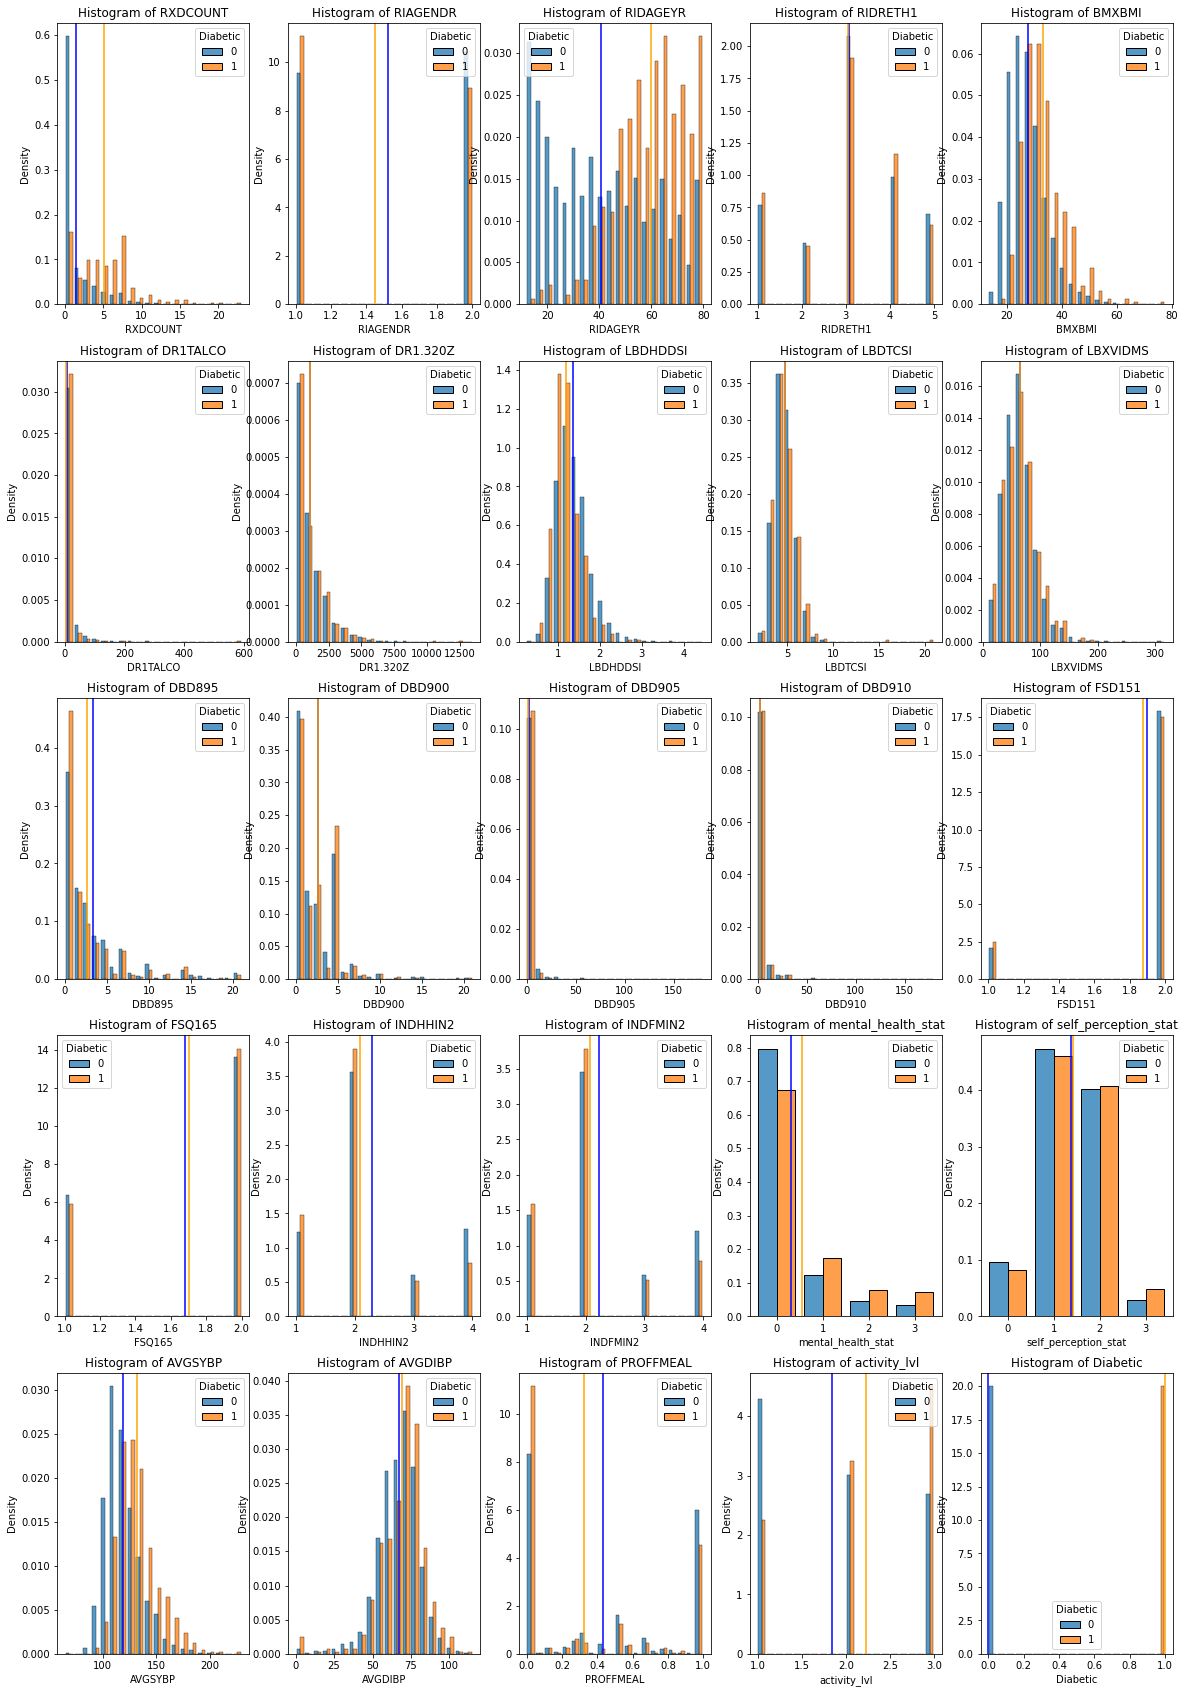

In [25]:
fig, axs = plt.subplots(5, 5,figsize=(20,30))
c=0
for n in combine.columns:
    i=int(c / 5)
    j=c%5
    axs[i,j].set_title('Histogram of ' + n)
    sns.histplot(ax=axs[i,j],data=combine, x=n, bins=20,hue='Diabetic',multiple="dodge", shrink=.8,common_norm=False,stat="density")
    tmp=combine.loc[combine['Diabetic']==0,n].values    
    axs[i,j].axvline(np.mean(tmp),color='blue')
    tmp=combine.loc[combine['Diabetic']==1,n].values    
    axs[i,j].axvline(np.mean(tmp),color='orange')
    c=c+1

plt.show()   
#fig.tight_layout()

For the EDA of the dataset, we will look at the difference between the 2 groups (diabetic and non-diabetic) using the 25 variables that we have identified. From the EDA, we can see that we have certain variables that have clear distinctions between the 2 groups. 

•	RXDCOUNT: Diabetics may have other underlying illnesses that they are taking medication for, thus may be the reason why they are taking more medications.

•	RIAGENDR: Interestingly, the distributions of gender in both groups are different, there are more women than men in the non-diabetics group and the inverse is true for the diabetics group

•	RIDAGEYR: We see the average age of diabetics in our list are generally older than the non-diabetics in our list, this could be because of aquired diabetes that occurs over the years, hence the mean age of diabetics is greater than mean age of non-diabetics.

•	BMXBMI: We have expected BMI to be one of the lead indicators of diabetics due to its correlation with obesity. From our background knowledge and 

•	LBDHDDSI: From our EDA, we can see that there are differences for Direct HDL-Cholesterol between the 2 groups. This could be due to the diabetic group having other underlying health issues such as high blood pressure or obesity that is the reason we are observing higher Direct HDL-Cholesterol levels in both groups.

•	DBD895: Interestingly, the number of meals prepared away from home or the number of take-away food is different between the 2 groups. This could be due to the differences between home-cooked food and take-away food, where take-away food often contain more sodium or other unhealthier ingredients such as oil, sugar etc which in turn could lead to diabetes over the years.

•	FSQ165: Surprisingly, Food stamp is slightly different between the 2 groups, although the general distribution of food stamps is quit eeven between the 2 groups. 

•	INDHHIN2/INDFMIN2: the mean of Household income and Family income between the 2 groups are quite clear and distinct, with the non-diabetic group reporting higher income than the diabetic group. This could be a sign that income levels can be 

•	mental_health_stat: from the EDA, we can see that the Diabetic group has a higher mental health stat score, which could be indicative that diabetics comes hand in hand with worse mental health than the the non-diabetic group.

•	AVGSYBP: from the histogram, we see that the average systolic blood pressure is higher for the diabetic group than the non-diabetic group, this could be a result of an other underlying health issue such as high blood pressure as well.

•	PROFFMEAL: the proportion of meals consumed out of home is quite distinct between the 2 groups, this could be the same reason as DBD895 where eating out could be considered more unhealthy than home-cooked meals.

•	activity_lvl: From the EDA, we see that the activity level is inversely proportional to the percentage of the sample group who are diabetic. The non-diabetic group seems to be much more active than the diabetic group.


# SECTION 4: MODEL BUILDING
## Model 1: Decision Tree

In [26]:
#Import required functions for model building
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

In [27]:
#Feature selector function
selector = SelectFromModel(DecisionTreeClassifier(random_state=42, class_weight='balanced'))
selector.fit(X_train,y_train)
selector.get_support()

array([ True, False,  True, False,  True, False,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False])

In [28]:
selected_features = X_train.columns[(selector.get_support())]

X_train_support = X_train[selected_features]
X_test_support = X_test[selected_features]

Using sklearn's inbuilt feature selector, we shortlist the features that contribute the largest degree of importance. This helps to further reduce the number of features that will need to be fit into the mdoel. We will be using these features in the development of the cross-validated decision tree model. The features are as follows:

In [29]:
selected_features

Index(['RXDCOUNT', 'RIDAGEYR', 'BMXBMI', 'DR1.320Z', 'LBDHDDSI', 'LBDTCSI', 'LBXVIDMS', 'AVGSYBP'], dtype='object')

The above features are (in order): RXDCOUNT: the number of medications the subject is prescribed with; RIDAGEYR: age in years; BMXBMI: Body Mass Index (BMI); DR1.320z: amount of water consumed in the first day of dietary recording; LBDHDDSI: The HDL cholesterol levels; LBDTCSI: Total cholesterol levels; LBXVIDMS: Vitamin D levels; AVGSYBP: Average systolic blood pressure.

As Decision Tree models are not optimised using a measure of Euclidean distance, there will not be a need to normalize the features. As such, we will pass the features directly through the Decision Tree Classifier. A random state of 42 is selected as consistent with the rest of the project and we initialize the 'balanced' class weight argument because of the imbalanced nature of this dataset.

In [30]:
tree_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

To obtain optimal validation scores for the model, we will run the decision tree model using GridSearchCV. This allows us to cross validate the data and select the best model based on the roc auc metric. The hyperparameters that we will be tuning would be the criterion and the max depth parameters of the decision tree. 

In [31]:
param_grid = {'criterion': ['gini','entropy'],'max_depth':[5,7,9,11,13,15]}

tree_cv = GridSearchCV(tree_model, param_grid,scoring='roc_auc', cv=5)

In [32]:
tree_cv.fit(X_train_support,y_train)
tree_cv.best_params_

{'criterion': 'entropy', 'max_depth': 5}

The chosen parameters for the Decision Tree model are using the entropy criterion and a max depth of 5. As the dependent variable that we are assessing is a binary categorical variable, we will evaluate this model using the Receiver Operator Characteristic (ROC) plot. This plot allows us to observe the diagnostic ability of this model as the discrimination threshold is modified.

Text(0, 0.5, 'True Positive Rate')

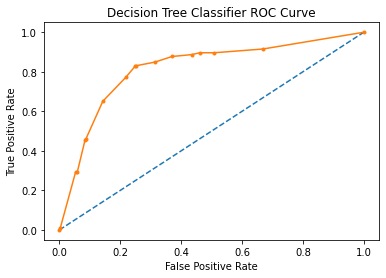

In [33]:
ns_probs = [0 for _ in range(len(y_test))]

probs = tree_cv.predict_proba(X_test_support)
probs = probs[:,1]

mid_fpr, mid_tpr, thresholds = roc_curve(y_test, ns_probs)
fpr, tpr, thresholds = roc_curve(y_test, probs.reshape(-1,1))

plt.plot(mid_fpr, mid_tpr,  linestyle='--', label='mid-line')
plt.plot(fpr, tpr,  marker='.')
plt.title('Decision Tree Classifier ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [34]:
y_proba_tree = tree_cv.predict_proba(X_test_support)[:,1]
roc_auc_score(y_test,y_proba_tree)

0.81772142995305

The trained decision tree has achieved an ROC AUC score of 0.8177. The Youden's statistic provides us with the optimum threshold value where both specificity and sensitivity are maximised. We will calculate the threshold value at the Youden's statistic. 

In [35]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.6047211122159711

Text(0.251, 0.3, 'Youdens Statistic')

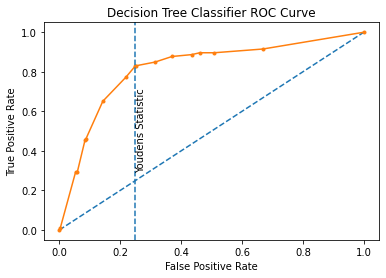

In [36]:
plt.plot(mid_fpr, mid_tpr,  linestyle='--', label='mid-line')
plt.plot(fpr, tpr,  marker='.')
plt.title('Decision Tree Classifier ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.axvline(x=fpr[np.where(thresholds==optimal_threshold)], linestyle='--')
plt.text(0.251,0.3,'Youdens Statistic',rotation=90)

Plotting this threshold value on the curve shows that it corresponds with the inflection point of the ROC curve. Using this threshold value, we can draw a set of predictions and calculate the classification report.

In [37]:
y_pred =(tree_cv.predict_proba(X_test_support)[:,1] >= optimal_threshold).astype(bool) # set threshold as 0.3

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1073
           1       0.25      0.83      0.38       106

    accuracy                           0.76      1179
   macro avg       0.61      0.79      0.62      1179
weighted avg       0.91      0.76      0.81      1179



From the above classification report, we can see that applying this threshold value to the model allows us to correctly identify 83% of diabetic cases. With a recall of 0.75, 25% of all non-diabetic cases get mis-classified, and given the 0.25 precision value of diabetic classes, 3 out of 4 subjects identified by the model do not have diabetes. 

However, in the practical application of this predictive model, subjects identified as at risk of diabetes may still require further testing to confirm that they meet the medical definitions for diagnosis. As such, the downside to a misclassification is non-lethal and might actually be helpful in identifying patients who may be prediabetic and in need of lifestyle modifications before their condition continues to develop further. 

To investigate the parameters that contribute to the identification of diabetes, we will plot the decision tree and look deeper into which parameters were selected as the most important at differentiating between diabetic and non-diabetic cases.  

[]

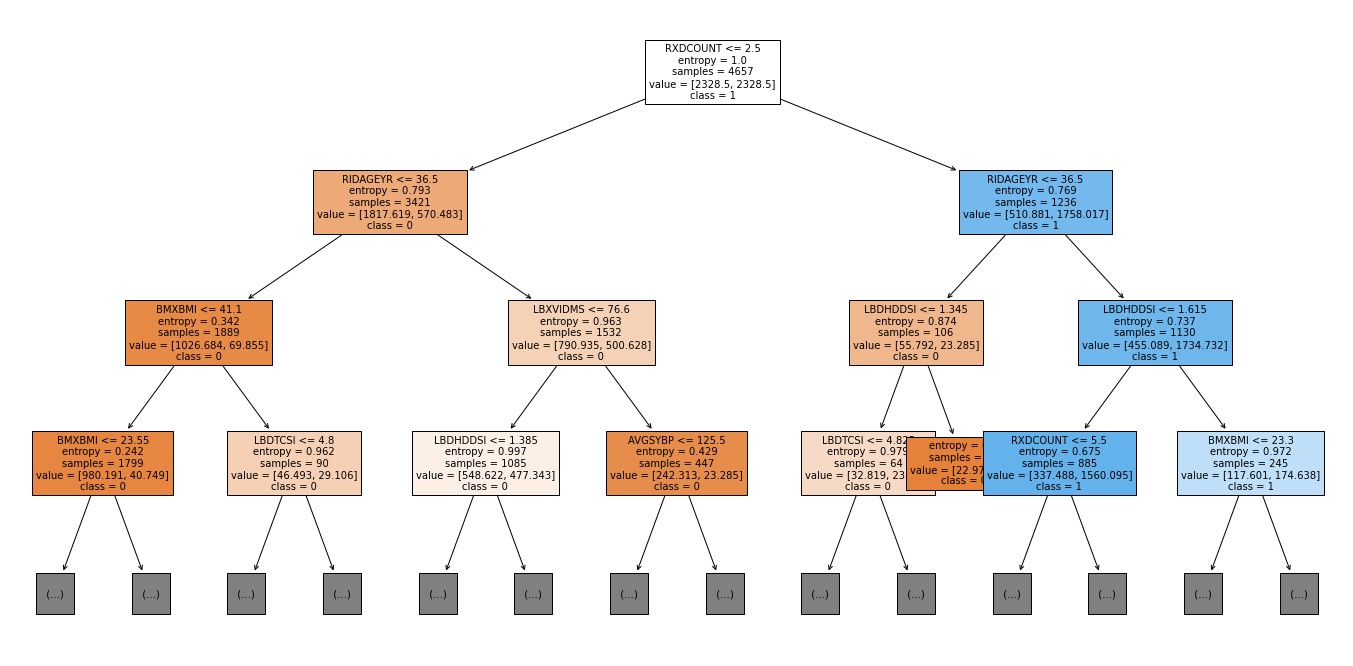

In [38]:
plt.figure(figsize=(24,12))
plot_tree(tree_cv.best_estimator_,max_depth=3,fontsize=10,feature_names = selected_features,class_names=['0','1'], filled=True)
plt.plot()

From the above visualisation of the tree, we can see that the variables RXDCOUNT (number of medications), RIDAGEYR (age in years), LBDHDDSI (HDL levels), BMXBMI (Body Mass Index) and LBXVIDMS (Serum vitamin D levels) seem to be important differentiating variables for diabetes. 

- RXDCOUNT as a variable may have been disproportionately indicative of diabetes because of the presence of diabetic-related medications in the subject records. The higher the number of medications that subjects are on, the higher the likelihood that one of the medications would be a diabetic drug. Given that our model is aimed at identifying diabetes before clinical diagnosis, including RXDCOUNT as one of the considered variables may offer an unfair advantage and we may have to remove the variable in a future iteration of the model. 

- The prevalence of diabetes increases with age and it is no surprise that RIDAGEYR is an important differentiating variable in this dataset. We can observe the decision tree model enforced a split to indicate that subjects aged 36.5 years and above have a higher likelihood of having diabetes. 

- Another variable of interest is LBDHDDSI, which is the serum HDL levels. HDL levels are an important measure of heart health and are often referred to as 'good cholesterol'. In this instance, we are able to see that the split identifying subjects who had HDL levels of 1.615 and below was able to separate a large proportion of diabetics. 

- BMXBMI is also an important variable distinguishing between classes. In the first 2 levels of the tree it is used to show that individuals with lower BMI will tend to have lower incidence of diabetes. This is consistent with public health literature which indicates that obesity is a strong risk factor for diabetes.

- The last variable of importance is LBXVIDMS. Vitamin D is often used as a proxy for healthy dietary practices or of an active lifestyle because the main 2 natural sources of Vitamin D is through whole foods such as fatty fish, egg yolks, liver, and through exposure to sunlight. Conversely, poor vitamin D levels may indicate poor dietary habits and a sedentary lifestyle. In this particular node, samples split because of lower serum vitamin D levels consist of a larger proportion of diabetics. This is also consistent with public health literature and shows the importance of vitamin D in predicting for diabetes.

  
  
## Model 2: Logistic Regression
  
  

In [39]:
#import relevant libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn import set_config
from sklearn.feature_selection import SelectFromModel, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
set_config(display='diagram')

In [40]:
#feature selection
#scale features
scaler = StandardScaler()
X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.fit_transform(X_test)

In [41]:
X_train_n

array([[-0.65649273, -1.03207968,  0.61814672, ...,  1.30015728,
        -0.98584454,  1.36233695],
       [-0.29962491, -1.03207968, -0.60907106, ..., -0.15846944,
        -0.98584454,  1.36233695],
       [ 0.41411074,  0.96891744,  1.15812255, ...,  2.10240197,
        -0.98584454,  1.36233695],
       ...,
       [ 1.84158204,  0.96891744,  1.55083224, ..., -0.74192013,
        -0.98584454,  1.36233695],
       [-0.65649273,  0.96891744, -1.09995817, ..., -0.01260677,
        -0.98584454, -1.0619669 ],
       [-0.65649273,  0.96891744, -0.26545008, ..., -0.66898879,
         1.3474481 ,  1.36233695]])

In [42]:
#feature selection
#identify features
selector = SelectFromModel(estimator=LogisticRegression()).fit(X_train_n, y_train)

In [43]:
selector.estimator_.coef_

array([[ 0.54295276, -0.16438249,  0.74908288, -0.04073132,  0.45676759,
        -0.03791534,  0.06421406, -0.4041    ,  0.04537174, -0.28566758,
        -0.01375021, -0.00399851,  0.01781761, -0.01532925,  0.00196538,
         0.04351864, -0.5550249 ,  0.61183225, -0.0366357 ,  0.16905227,
         0.24183157, -0.03537392, -0.08446982,  0.07163629]])

In [44]:
selector.threshold_

0.19555925296727497

In [45]:
selector.get_support()

array([ True, False,  True, False,  True, False, False,  True, False,
        True, False, False, False, False, False, False,  True,  True,
       False, False,  True, False, False, False])

In [46]:
selector.transform(X_train_n)

array([[-0.65649273,  0.61814672, -0.5123312 , ..., -0.28967565,
        -0.23465744,  1.82647722],
       [-0.29962491, -0.60907106, -1.96462581, ..., -0.28967565,
        -0.23465744, -0.66149215],
       [ 0.41411074,  1.15812255, -0.18037815, ..., -1.31398809,
        -1.25311012,  2.86795277],
       ...,
       [ 1.84158204,  1.55083224, -0.85811563, ..., -0.28967565,
        -0.23465744,  0.3799834 ],
       [-0.65649273, -1.09995817, -0.62298222, ...,  0.7346368 ,
         0.78379523, -0.77721166],
       [-0.65649273, -0.26545008,  0.70483   , ..., -0.28967565,
        -0.23465744, -1.00865067]])

In [47]:
X_train.columns[selector.get_support()]

Index(['RXDCOUNT', 'RIDAGEYR', 'BMXBMI', 'LBDHDDSI', 'LBXVIDMS', 'INDHHIN2', 'INDFMIN2', 'AVGSYBP'], dtype='object')

The above features are: 
RXDCOUNT: the number of medications the subject is prescribed with; 
RIDAGEYR: age in years; 
BMXBMI: Body Mass Index (BMI); 
LBDHDDSI: The HDL cholesterol levels; 
LBXVIDMS: Vitamin D levels; 
INDHHIN2: Annual Household Income;
INDFMIN2: Annual Family Income;
AVGSYBP: Average systolic blood pressure.

Similar to the Decision Tree model, A random state of 42 is selected as consistent with the rest of the project and we initialize the 'balanced' class weight argument because of the imbalanced nature of this dataset.

In [48]:
#identified features
num_list = ['RXDCOUNT', 'RIDAGEYR', 'BMXBMI', 'LBDHDDSI', 'LBXVIDMS', 'AVGSYBP']
cat_list= ['INDHHIN2', 'INDFMIN2', ]
all_features = num_list + cat_list

In [49]:
X_train = X_train.loc[:, all_features]
X_test = X_test.loc[:, all_features]

In [50]:
ct = ColumnTransformer([
      ('scale', StandardScaler(),[0,1,2,3,4,5]),
      ('onehot', OneHotEncoder(),[6,7])])

In [51]:
ct.fit(X_train)

ColumnTransformer(transformers=[('scale', StandardScaler(), [0, 1, 2, 3, 4, 5]),
                                ('onehot', OneHotEncoder(), [6, 7])])

In [52]:
X_ttrain = ct.transform(X_train)
X_ttest = ct.transform(X_test)

In [53]:
#import log reg
from sklearn import linear_model
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [54]:
lm = LogisticRegression(random_state=42,max_iter=500, class_weight='balanced')

In [55]:
param_grid = {'penalty':['l2', 'none'],'C':[0.01,0.1,1,10,100],}
logreg_cv = GridSearchCV(lm, param_grid, scoring='roc_auc', cv=5)

In [56]:
logreg_cv.fit(X_ttrain,y_train)
logreg_cv.best_params_

E:\Users\tay_w\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
E:\Users\tay_w\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
E:\Users\tay_w\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
E:\Users\tay_w\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
E:\Users\tay_w\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
E:\Users\tay_w\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalt

{'C': 0.01, 'penalty': 'l2'}

Text(0, 0.5, 'True Positive Rate')

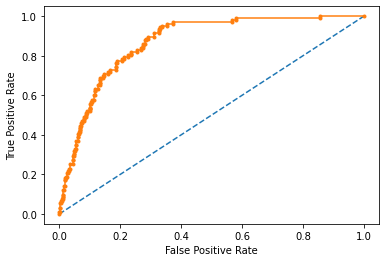

In [57]:
ns_probs = [0 for _ in range(len(y_test))]

probs = logreg_cv.predict_proba(X_ttest)
probs = probs[:,1]

mid_fpr, mid_tpr, thresholds = roc_curve(y_test, ns_probs)
fpr, tpr, thresholds = roc_curve(y_test, probs.reshape(-1,1))

plt.plot(mid_fpr, mid_tpr,  linestyle='--', label='mid-line')
plt.plot(fpr, tpr,  marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [58]:
print(f'The area under the AUC is {auc(fpr, tpr):.3f}.')

The area under the AUC is 0.870.


In [59]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.3409257806917801

Text(0.35, 0.42, 'Youdens Statistic')

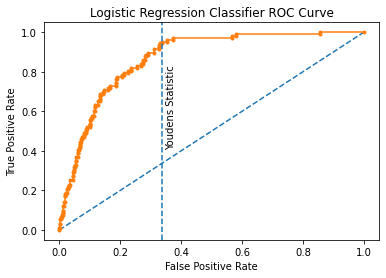

In [60]:
plt.plot(mid_fpr, mid_tpr,  linestyle='--', label='mid-line')
plt.plot(fpr, tpr,  marker='.')
plt.title('Logistic Regression Classifier ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.axvline(x=fpr[np.where(thresholds==optimal_threshold)], linestyle='--')
plt.text(0.35,0.42,'Youdens Statistic',rotation=90)

In [61]:
y_pred =(logreg_cv.predict_proba(X_ttest)[:,1] >= optimal_threshold).astype(bool) # set optimal threshold

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.66      0.80      1073
           1       0.22      0.95      0.36       106

    accuracy                           0.69      1179
   macro avg       0.61      0.81      0.58      1179
weighted avg       0.92      0.69      0.76      1179



In [62]:
#Visualing log reg coefficients
#create column list
df1 = pd.get_dummies(X_train.INDHHIN2, prefix = "INDHHIN2")
df2 = pd.get_dummies(X_train.INDHHIN2, prefix = "INDFMIN2")
result = pd.concat([df1, df2], axis=1, join="inner")
col_list = num_list + list(result.columns)

In [63]:
X_ttrain_new = pd.DataFrame(X_ttrain, 
             columns=col_list)
X_ttrain_new

,RXDCOUNT,RIDAGEYR,BMXBMI,LBDHDDSI,LBXVIDMS,AVGSYBP,INDHHIN2_1.0,INDHHIN2_2.0,INDHHIN2_3.0,INDHHIN2_4.0,INDFMIN2_1.0,INDFMIN2_2.0,INDFMIN2_3.0,INDFMIN2_4.0
0,-0.656493,0.618147,-0.512331,-1.147657,-0.944521,1.826477,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.299625,-0.609071,-1.964626,-0.184673,-0.904605,-0.661492,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.414111,1.158123,-0.180378,-0.640823,0.361803,2.867953,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.057243,0.225437,-0.954935,0.094086,1.087538,-0.892931,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.656493,-0.020007,1.230422,-0.311381,-0.222414,-0.661492,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4652,-0.656493,-0.314539,-0.650645,-0.438090,0.336402,-0.082895,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4653,0.057243,1.354477,-0.871947,0.018061,-1.046124,2.000056,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4654,1.841582,1.550832,-0.858116,-1.147657,1.762472,0.379983,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4655,-0.656493,-1.099958,-0.622982,1.791979,-0.744943,-0.777212,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [64]:
lm = LogisticRegression(penalty = 'l2', C = 0.01, random_state=42,max_iter=500, class_weight='balanced')
lm.fit(X_ttrain_new, y_train)
odds = np.exp(lm.coef_[0])

pd.DataFrame(odds, 
             X_ttrain_new.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
RIDAGEYR,2.014130
RXDCOUNT,1.946588
BMXBMI,1.497168
AVGSYBP,1.315258
INDHHIN2_2.0,1.083872
INDFMIN2_3.0,1.070988
INDHHIN2_3.0,1.059610
INDFMIN2_2.0,1.029553
INDFMIN2_4.0,0.974970
INDHHIN2_1.0,0.950402


For every one-unit increase in the independent variable, the odds that the observation is diabetic is its  coefficient's times as large as the odds that the observation is not diabetic when all other variables are held constant.

We can see that "RIDAGEYR"; "RXDCOUNT"; "BMXBMI"; "AVGSYBP" are more impactful in affecting the odds, with the first 3 variables also reflected earlier in the Decision Tree model.

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [90]:
#Feature selector function
selector = SelectFromModel(RandomForestClassifier(random_state=42, class_weight='balanced'))
selector.fit(X_train,y_train)
selector.get_support()

array([ True, False,  True, False,  True, False, False,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False])

In [91]:
X_train

,RXDCOUNT,RIAGENDR,RIDAGEYR,RIDRETH1,BMXBMI,DR1TALCO,DR1.320Z,LBDHDDSI,LBDTCSI,LBXVIDMS,DBD895,DBD900,DBD905,DBD910,FSD151,FSQ165,INDHHIN2,INDFMIN2,mental_health_stat,self_perception_stat,AVGSYBP,AVGDIBP,PROFFMEAL,activity_lvl
0,0.0,1,55,5,24.6,29.1,0.0,0.91,4.65,38.4,0.0,5.0,0.0,0.0,2.0,2.0,2.0,2.0,0,2,152.0,85.0,0.000000,3.0
1,1.0,1,30,5,14.1,0.0,240.0,1.29,4.06,39.5,0.0,5.0,0.0,0.0,1.0,1.0,2.0,2.0,1,2,109.0,65.0,0.000000,3.0
2,3.0,2,66,2,27.0,4.7,150.0,1.11,6.39,74.4,0.0,5.0,0.0,0.0,2.0,1.0,1.0,1.0,3,2,170.0,96.0,0.000000,3.0
3,2.0,2,47,5,21.4,0.0,1095.0,1.40,4.76,94.4,3.0,2.0,1.0,2.0,2.0,2.0,3.0,3.0,0,1,105.0,65.0,0.666667,1.0
4,0.0,2,42,3,37.2,0.0,5760.0,1.24,3.18,58.3,10.0,5.0,15.0,15.0,2.0,2.0,3.0,3.0,0,1,109.0,68.0,0.500000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5308,0.0,1,36,3,23.6,11.2,180.0,1.19,3.54,73.7,5.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,0,2,119.0,85.0,0.600000,1.0
5309,2.0,2,70,4,22.0,0.0,525.0,1.37,4.97,35.6,5.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,0,2,155.0,80.0,0.000000,3.0
5310,7.0,2,74,3,22.1,19.2,1575.0,0.91,5.51,113.0,2.0,0.0,12.0,0.0,2.0,2.0,2.0,2.0,0,2,127.0,57.0,0.000000,3.0
5312,0.0,2,20,4,23.8,0.0,75.0,2.07,4.22,43.9,0.0,5.0,2.0,3.0,2.0,2.0,3.0,3.0,0,1,107.0,67.0,0.000000,1.0


In [94]:
selected_features = X_train.columns[(selector.get_support())]

X_train_rf = X_train[selected_features]
X_test_rf = X_test[selected_features]

,RXDCOUNT,RIDAGEYR,BMXBMI,LBDHDDSI,LBDTCSI,LBXVIDMS,AVGSYBP,AVGDIBP
0,0.0,55,24.6,0.91,4.65,38.4,152.0,85.0
1,1.0,30,14.1,1.29,4.06,39.5,109.0,65.0
2,3.0,66,27.0,1.11,6.39,74.4,170.0,96.0
3,2.0,47,21.4,1.40,4.76,94.4,105.0,65.0
4,0.0,42,37.2,1.24,3.18,58.3,109.0,68.0
...,...,...,...,...,...,...,...,...
5308,0.0,36,23.6,1.19,3.54,73.7,119.0,85.0
5309,2.0,70,22.0,1.37,4.97,35.6,155.0,80.0
5310,7.0,74,22.1,0.91,5.51,113.0,127.0,57.0
5312,0.0,20,23.8,2.07,4.22,43.9,107.0,67.0


In [95]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

In [114]:
param_grid = {'n_estimators':[100,200,300,400,500],'criterion': ['gini','entropy'],'max_depth':[5,7,9,11,13,15,17,19]}

rf_cv = GridSearchCV(rf_model, param_grid,scoring='roc_auc', cv=5)

In [115]:
rf_cv.fit(X_train,y_train)
rf_cv.best_params_

{'criterion': 'entropy', 'max_depth': 19, 'n_estimators': 400}

Text(0.35, 0.42, 'Youdens Statistic')

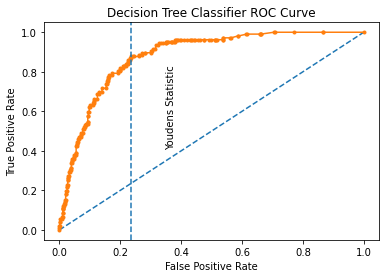

In [116]:
ns_probs = [0 for _ in range(len(y_test))]

probs = rf_cv.predict_proba(X_test)
probs = probs[:,1]

mid_fpr, mid_tpr, thresholds = roc_curve(y_test, ns_probs)
fpr, tpr, thresholds = roc_curve(y_test, probs.reshape(-1,1))

plt.plot(mid_fpr, mid_tpr,  linestyle='--', label='mid-line')
plt.plot(fpr, tpr,  marker='.')
plt.title('Decision Tree Classifier ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

plt.axvline(x=fpr[np.where(thresholds==optimal_threshold)], linestyle='--')
plt.text(0.35,0.42,'Youdens Statistic',rotation=90)

In [117]:
roc_auc_score(y_test,probs)

0.8818029154724014

In [118]:
y_pred_rf =(rf_cv.predict_proba(X_test)[:,1] >= optimal_threshold).astype(bool) # set optimal threshold

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.98      0.76      0.86      1073
           1       0.27      0.88      0.41       106

    accuracy                           0.77      1179
   macro avg       0.63      0.82      0.64      1179
weighted avg       0.92      0.77      0.82      1179

